In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict




In [2]:


data_dir = 'flowers'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'


data_transforms_train = transforms.Compose([transforms.Resize(256),transforms.RandomRotation([-30,30]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


data_transforms_test_eval = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


trainset = datasets.ImageFolder(train_dir, transform=data_transforms_train)
testset = datasets.ImageFolder(test_dir, transform=data_transforms_test_eval)
#trainset = datasets.DatasetFolder(train_dir, transform=data_transforms_train)
#testset = datasets.DatasetFolder(test_dir, transform=data_transforms_test_eval)
                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)                                                


torch.Size([64, 3, 224, 224])
torch.Size([64])


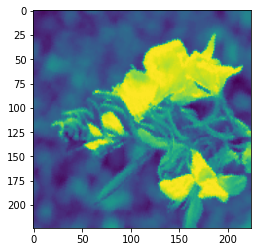

In [3]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [26]:
model = models.resnet152(pretrained=True)
input_size = 2048
hidden_sizes = [1024,512,256]
output_size = 102

for param in model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1',nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2',nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('dropout3',nn.Dropout(p=0.1)),
                          ('fc4', nn.Linear(hidden_sizes[2], output_size))
                          #('output', nn.LogSoftmax(dim=1))
                          ]))
        
model.fc = classifier 

In [27]:
epochs=10
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)  #had to change from SGD to Adam but later noy much difference
#lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [28]:
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.to(device)

    for epoch in range(epochs):
        model.train()

        for step,(inputs,labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            inputs=inputs.to(device)
            labels=labels.to(device)

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model.forward(inputs)   #this is 64 (bacth_size)*10
            
            if(count==0): print(y_pred.size(),labels.size())
            loss=criterion(y_pred,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(labels.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            #print(count)
            if(step%40==0): 
                print('epoch',epoch+1,'/',epochs,'train running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))
                print('-----')
                test_function(test_loader)
                print('---------------------')
                model.train()
            
        #check_loss=(loss_running/count_batch)
        #lr_scheduler_.step(check_loss)



In [29]:
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.eval()
    
    with torch.no_grad():
        
        for _,(inputs,labels) in enumerate(test_loader):
            
            
            inputs=inputs.to(device)
            labels=labels.to(device)

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model.forward(inputs)   #this is 64 (bacth_size)*10

            #if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            count=count+1
            #print('count_test',count)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
        print('test running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




#test_function(test_loader)   # w/o convnet :result show over fitting on train 64%, but overall 50% on test is not too bad wihtout convnet
#w/ convnet just after 5 epoch training the test got to 63% (50% train)
#after 10 epoch test get to 66% pretty good without big networks

#CiFAR10 with inception better in training improve to 64% but not much better for test at 64% (may be need derop out and more fc)

#after more fc on top of inception got to 70% test, 

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_function(train_loader)

cuda
torch.Size([64, 102]) torch.Size([64])
epoch 1 / 10 train running_loss: 0.07215459644794464 Accuracy 0.0
-----
test running_loss: 0.07203517796901557 Accuracy 2.2836538461538463
---------------------
epoch 1 / 10 train running_loss: 0.07067731531654917 Accuracy 4.496951219512195
-----
test running_loss: 0.06746628364691368 Accuracy 11.41826923076923
---------------------
epoch 1 / 10 train running_loss: 0.06707422104146746 Accuracy 7.445987654320987
-----
test running_loss: 0.05719017380705246 Accuracy 13.701923076923077
---------------------
epoch 2 / 10 train running_loss: 0.0645331674071869 Accuracy 9.401451027811367
-----
test running_loss: 0.049441224393936306 Accuracy 17.908653846153847
---------------------
epoch 2 / 10 train running_loss: 0.05940368015452271 Accuracy 13.469921534437663
-----
test running_loss: 0.041596404634989224 Accuracy 28.365384615384617
---------------------
epoch 2 / 10 train running_loss: 0.05503031052775991 Accuracy 17.92774369461486
-----
test run

In [20]:
import torch
print(torch.__version__)

0.4.0


In [ ]:
# class AlexNet_mod(nn.Module):

#     def __init__(self, num_classes=10):
#         super(AlexNet_mod, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.BatchNorm2d(64)
            
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.BatchNorm2d(192)
            
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(384)
            
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(256)
            
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.BatchNorm2d(256)
            
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 1000),   # 1000 removed
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(1000, 10),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), 256 * 6 * 6)
#         x = self.classifier(x)
#         return x